# Army OER Pipeline

## Section 1: Introduction

The goal of this notebook is to implement a document pre-processing pipeline to extract the comments sections from Army Officer Evaluation Reports (OERs) and stage them for a labeling task in LabelStudio.

In [ ]:
import os
import json


def get_filename(directory, filename):
    cwd = os.getcwd()
    local_directory = os.path.join(os.path.split(cwd)[0], directory)
    ci_directory = os.path.join(cwd, directory)

    if os.path.exists(local_directory) and filename in os.listdir(local_directory):
        return os.path.join(local_directory, filename)
    elif os.path.exists(ci_directory) and filename in os.listdir(ci_directory):
        return os.path.join(ci_directory, filename)
    else:
        raise FileNotFoundError

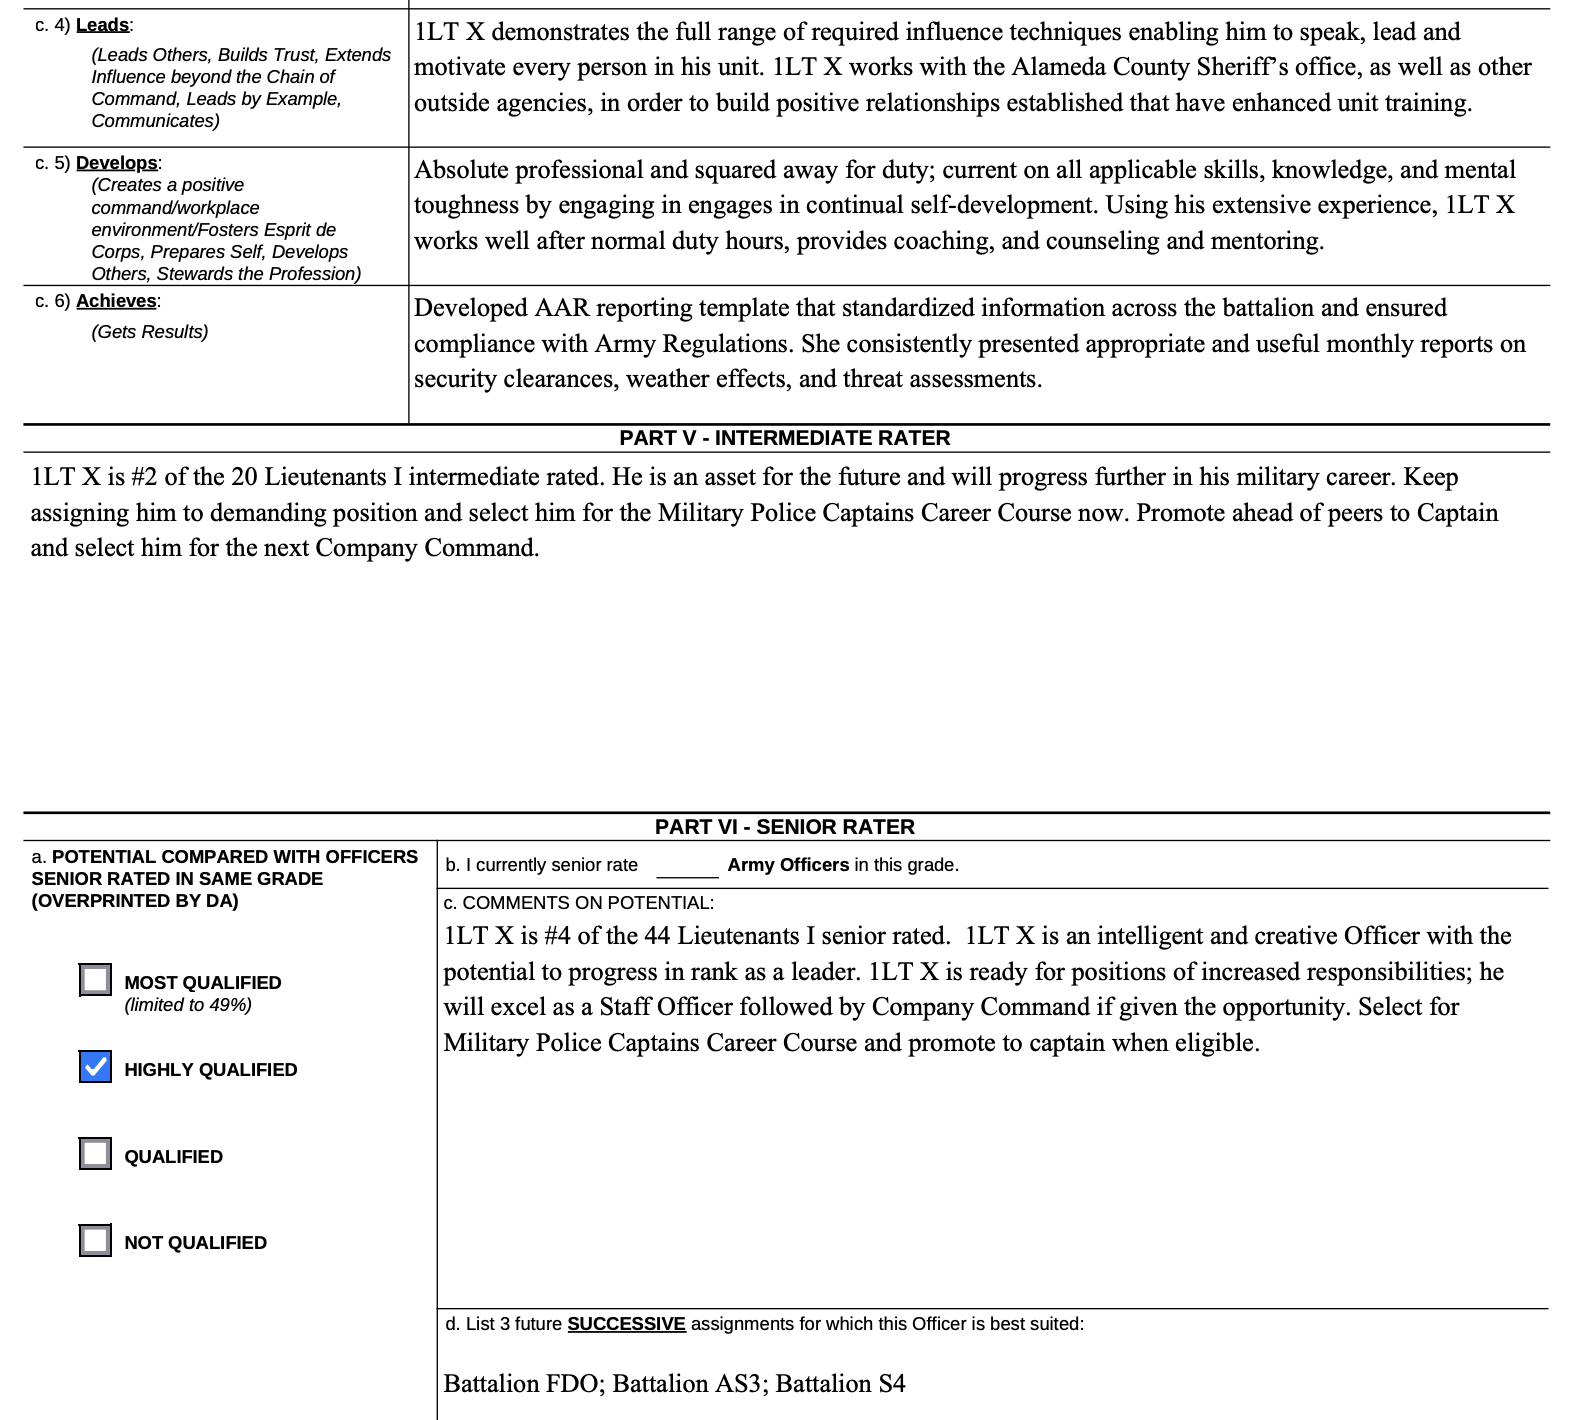

In [ ]:
from IPython.display import Image

sample_image = get_filename("img", "oer-screenshot.png")
Image(filename=sample_image) 

```json
{
    "duty_description": "Personnel and Administration Officer (S1) for a training battalion in the U.S. Army reserve. Principal staff assistant to the battalion commander. Exercise staff supervisor in matters pertaining to strength management, personnel qualifications and evaluations, personnel assignment, clearance, recruiting, retention, and battalion administration. Responsible for the overall supervision of the battalion Personnel Administration Center (PAC) and its activities. Serves as commander of Headquarters and Headquarters Detachment. Additional duties include; Battalion Safety Officer, Equal Opportunity Officer, Records Management Officer, and Retention Officer.",
    "rater_comments": "1LT X performed flawlessly in the execution of an overseas detention and area security mission at Guantanamo Bay, Cuba. Exceptional performance during this limited rating period by CPT X.",
    "rater_sections": {
        "achieves": "Developed AAR reporting template that standardized information across the battalion and ensured compliance with Army Regulations. She consistently presented appropriate and useful monthly reports on security clearances, weather effects, and threat assessments.", ...
    },
    "senior_rater_comments": {
        "comments": "I currently senior rate Army Officers in this grade. 1LT X is an intelligent and creative Officer with the potential to progress in rank as a leader. 1LT X is ready for positions of increased responsibilities; he will excel as a Staff Officer followed by Company Command if given the opportunity. Select for Military Police Captains Career Course and promote to captain when eligible.",
        "next_assignment": [
            "Battalion FDO",
            " Battalion AS3",
            " Battalion S4"
        ]
    }, ...
}
```

In [ ]:
# pipeline-api
VALID_MODES = ["prod", "local"]

def get_layout_url(inference_mode: str = "prod"):
    if inference_mode not in VALID_MODES:
        raise ValueError(f"Invalid mode. Valid modes are {VALID_MODES}")
    
    if inference_mode == "prod":
        return "https://ml.unstructured.io/layout/pdf"
    elif inference_mode == "local":
        return "http://localhost:8000/layout/pdf"

In [ ]:
# pipeline-api
import requests

def partition_oer(
    file,
    filename,
    file_content_type=None,
    include_elems=["Text", "Title", "Table"],
    inference_mode: str = "prod",
    model=None
):
    url = get_layout_url(inference_mode)
    if model is None:
        data = {"include_elems" : include_elems}
    else:
        data = {"model" : model}
    file.seek(0)
    response = requests.post(
        url,
        files={"file": (filename, file, file_content_type)},
        data=data
    )
    partition_result = json.loads(response.content.decode("utf-8"))
    return partition_result

In [ ]:
filename = get_filename("sample-docs", "fake-oer.pdf")
with open(filename, "rb") as f:
    pages = partition_oer(f, filename)["pages"]
    cb_pages = partition_oer(f, filename, model="checkbox")["pages"]

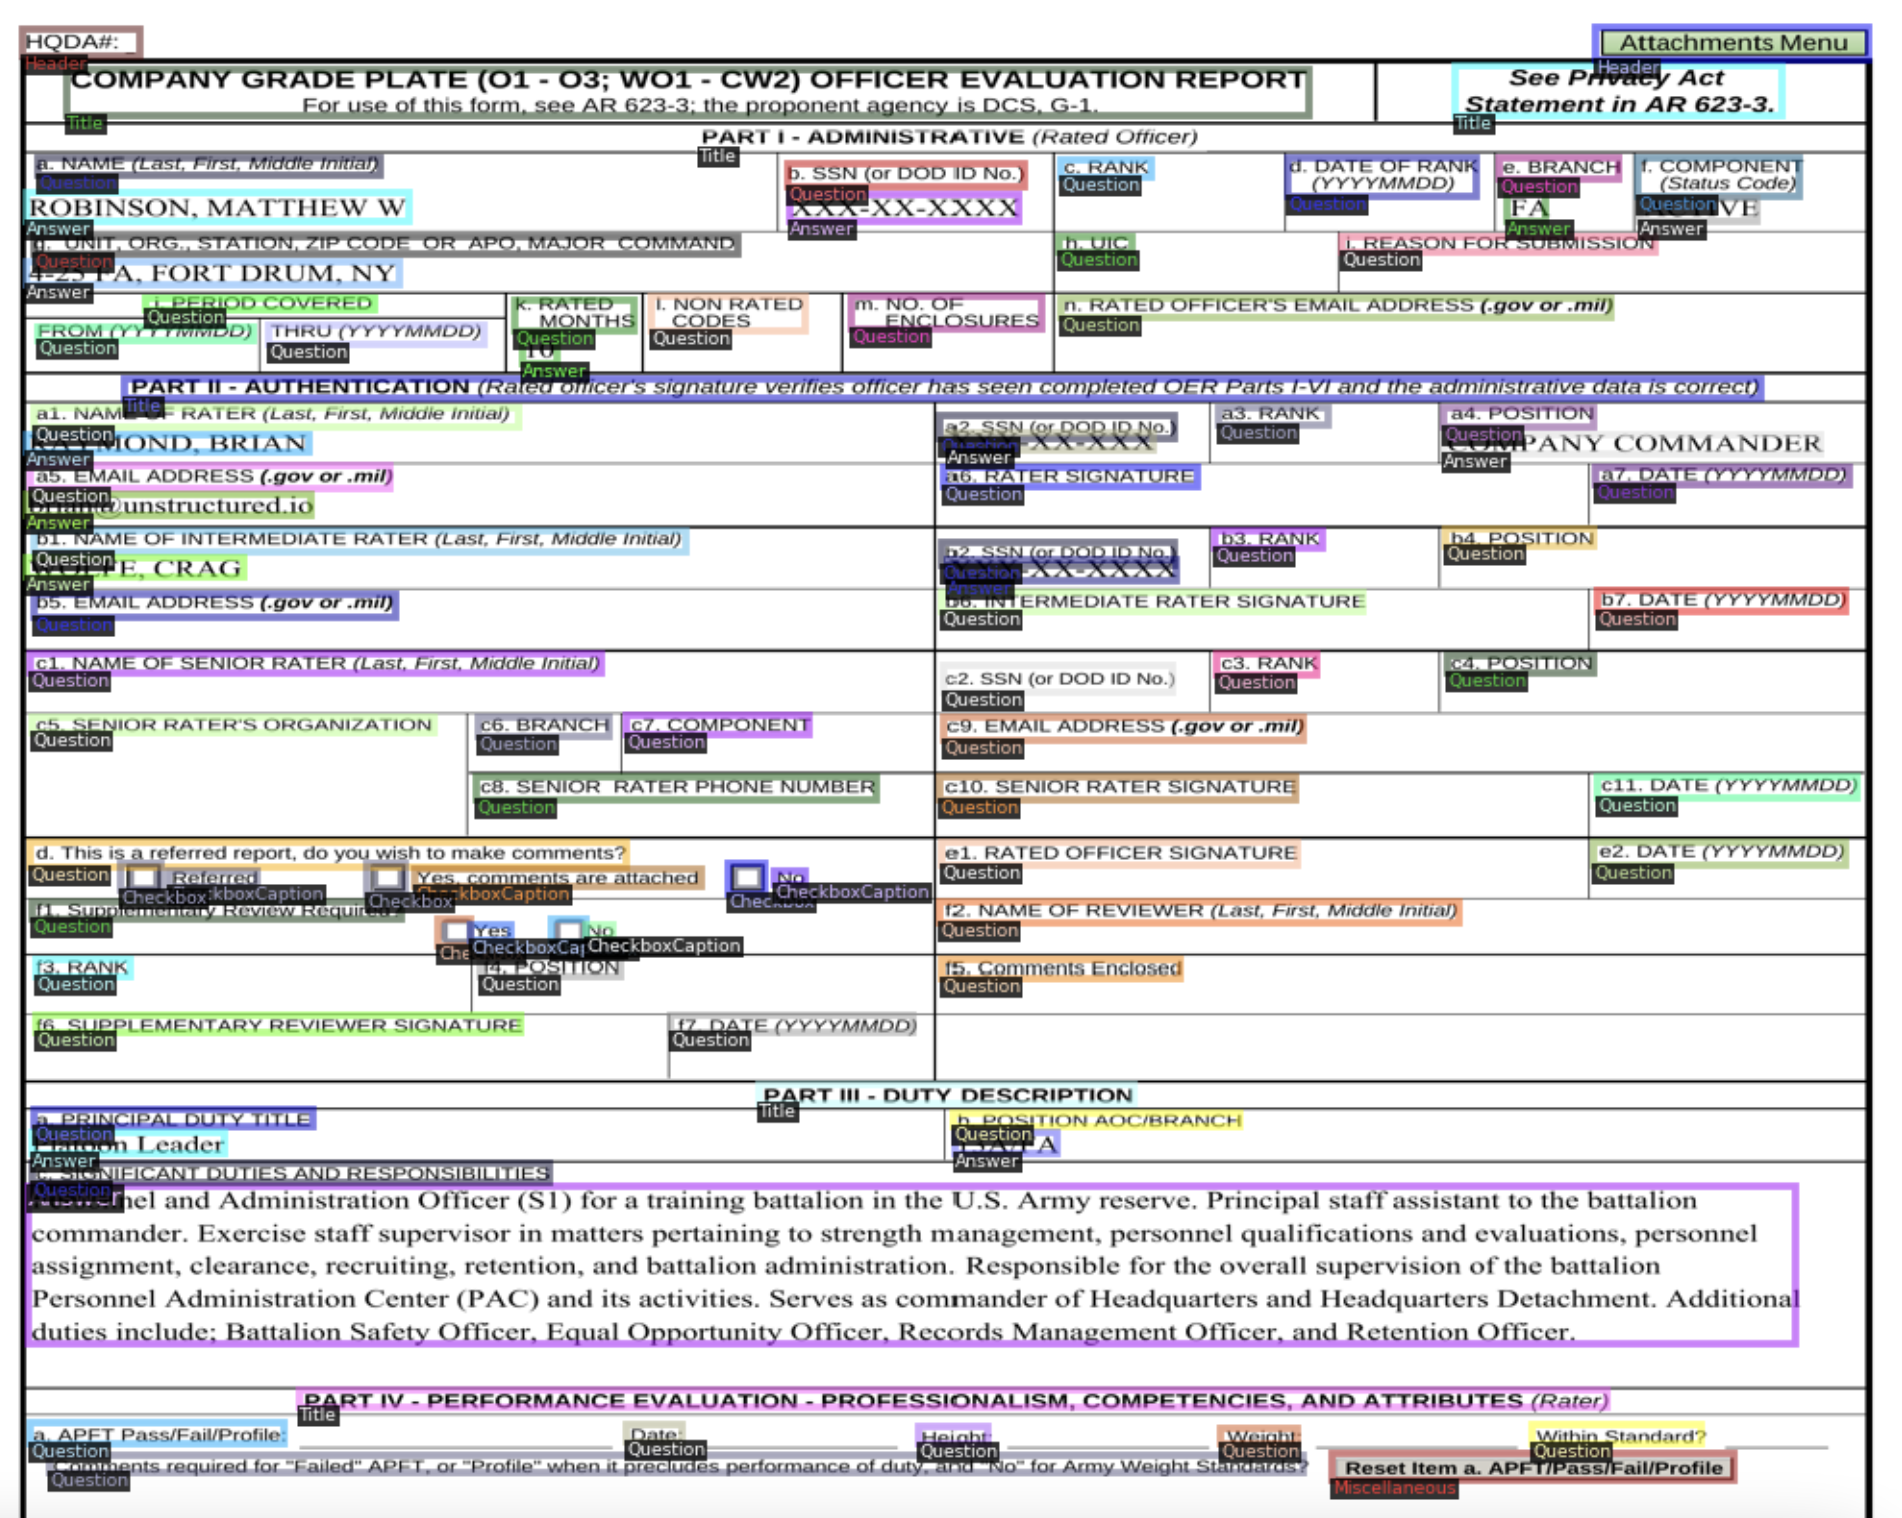

In [ ]:
sample_image = get_filename("img", "oer-boxes.png")
Image(filename=sample_image) 

In [ ]:
pages[0]["elements"][1]

{'type': 'Text',
 'coordinates': [[23.71831512451172, 476.9766540527344],
  [571.743896484375, 476.9766540527344],
  [571.743896484375, 549.2498779296875],
  [23.71831512451172, 549.2498779296875]],
 'text': 'c. SIGNIFICANT DUTIES AND RESPONSIBILITIES Personnel and Administration Officer (S1) for a training battalion in the U.S. Army reserve. Principal staff assistant to the battalion commander. Exercise staff supervisor in matters pertaining to strength management, personnel qualifications and evaluations, personnel assignment, clearance, recruiting, retention, and battalion administration. Responsible for the overall supervision of the battalion Personnel Administration Center (PAC) and its activities. Serves as commander of Headquarters and Headquarters Detachment. Additional duties include; Battalion Safety Officer, Equal Opportunity Officer, Records Management Officer, and Retention Officer.'}

In [ ]:
cb_pages[0]["elements"][1]

{'type': 'Unchecked',
 'coordinates': [[237.96682739257812, 352.9676818847656],
  [251.81820678710938, 352.9676818847656],
  [251.81820678710938, 365.1590881347656],
  [237.96682739257812, 365.1590881347656]],
 'text': ''}

## Section 2: Cleaning Bricks

Cleaning bricks remove text that is not needed for downstream applications, such as data labeling and model inference. In this case, we will use the off the shelf `clean_prefix` and `clean_extra_whitespace` cleaning brick to remove section titles and line breaks.

In [ ]:
text = pages[0]["elements"][1]["text"]
text

'c. SIGNIFICANT DUTIES AND RESPONSIBILITIES Personnel and Administration Officer (S1) for a training battalion in the U.S. Army reserve. Principal staff assistant to the battalion commander. Exercise staff supervisor in matters pertaining to strength management, personnel qualifications and evaluations, personnel assignment, clearance, recruiting, retention, and battalion administration. Responsible for the overall supervision of the battalion Personnel Administration Center (PAC) and its activities. Serves as commander of Headquarters and Headquarters Detachment. Additional duties include; Battalion Safety Officer, Equal Opportunity Officer, Records Management Officer, and Retention Officer.'

In [ ]:
# pipeline-api
import re

from unstructured.cleaners.core import clean_prefix, clean_extra_whitespace

BLOCK_TITLE_PATTTERN = (
    r"c. (SIGNIFICANT DUTIES AND RESPONSIBILITIES|COMMENTS ON POTENTIAL):?"
)

In [ ]:
clean_description = clean_prefix(text, BLOCK_TITLE_PATTTERN)
clean_extra_whitespace(clean_description)

'Personnel and Administration Officer (S1) for a training battalion in the U.S. Army reserve. Principal staff assistant to the battalion commander. Exercise staff supervisor in matters pertaining to strength management, personnel qualifications and evaluations, personnel assignment, clearance, recruiting, retention, and battalion administration. Responsible for the overall supervision of the battalion Personnel Administration Center (PAC) and its activities. Serves as commander of Headquarters and Headquarters Detachment. Additional duties include; Battalion Safety Officer, Equal Opportunity Officer, Records Management Officer, and Retention Officer.'

## Section 3: Custom Brick Combos

#### Senior Rater Comments

You can also use combinations of bricks to isolate important sections of text. Here, we use the `extract_text_after`, `extract_text_before`, and `clean_postfix` bricks to identify the section of text that corresponds to the senior rater comments in the OER.

In [ ]:
pages[1]["elements"][-2]

{'type': 'Table',
 'coordinates': [[34.6771354675293, 517.2210693359375],
  [576.9398193359375, 517.2210693359375],
  [576.9398193359375, 736.869384765625],
  [34.6771354675293, 736.869384765625]],
 'text': 'PART VI - SENIOR RATER POTENTIAL COMPARED WITH OFFICERS SENIOR RATED IN SAME GRADE (OVERPRINTED BY DA) MOST QUALIFIED (limited to 49%) HIGHLY QUALIFIED QUALIFIED NOT QUALIFIED b. I currently senior rate Army Officers in this grade. 1LT X is #4 of the 44 Lieutenants I senior rated. 1LT X is an intelligent and creative Officer with the potential to progress in rank as a leader. 1LT X is ready for positions of increased responsibilities; he will excel as a Staff Officer followed by Company Command if given the opportunity. Select for Military Police Captains Career Course and promote to captain when eligible. c. COMMENTS ON POTENTIAL: d. List 3 future SUCCESSIVE assignments for which this Officer is best suited: Battalion FDO; Battalion AS3; Battalion S4'}

In [ ]:
# pipeline-api
from unstructured.cleaners.core import clean_postfix
from unstructured.cleaners.extract import (
    extract_text_after, extract_text_before
)


SENIOR_RATER_PREFIX = (r"PART VI - SENIOR RATER POTENTIAL COMPARED WITH OFFICERS SENIOR RATED IN SAME GRADE "
                       r"\(OVERPRINTED BY DA\) MOST QUALIFIED "
                       r"\(limited to 49%\) HIGHLY QUALIFIED QUALIFIED NOT QUALIFIED b. ")
        
NEXT_ASSIGNMENT_PREFIX = "d. List 3 future SUCCESSIVE assignments for which this Officer is best suited: "

def get_senior_rater_comments(pages):
    for element in pages[1]["elements"]:
        if re.search(SENIOR_RATER_PREFIX, element["text"]):
            raw_comments = clean_prefix(element["text"], SENIOR_RATER_PREFIX)

            sr_rater_comments = extract_text_before(raw_comments, NEXT_ASSIGNMENT_PREFIX)
            sr_rater_comments = clean_postfix(
                sr_rater_comments, BLOCK_TITLE_PATTTERN
            )

            next_assigments = extract_text_after(raw_comments, NEXT_ASSIGNMENT_PREFIX)

            return {"comments": sr_rater_comments, "next_assignment": next_assigments.split(";")}

    return dict()

In [ ]:
get_senior_rater_comments(pages)

{'comments': 'I currently senior rate Army Officers in this grade. 1LT X is #4 of the 44 Lieutenants I senior rated. 1LT X is an intelligent and creative Officer with the potential to progress in rank as a leader. 1LT X is ready for positions of increased responsibilities; he will excel as a Staff Officer followed by Company Command if given the opportunity. Select for Military Police Captains Career Course and promote to captain when eligible.',
 'next_assignment': ['Battalion FDO', ' Battalion AS3', ' Battalion S4']}

In [ ]:
pages[1]["elements"][0]["text"]

'c. 1) Character : Developed AAR reporting template that standardized information across the battalion and ensured compliance with Army Regulations. She consistently presented appropriate and useful monthly reports on security clearances, weather effects, and threat assessments. (Gets Results) c. 6) Achieves : Absolute professional and squared away for duty; current on all applicable skills, knowledge, and mental toughness by engaging in engages in continual self-development. Using his extensive experience, 1LT X works well after normal duty hours, provides coaching, and counseling and mentoring. (Creates a positive command/workplace environment/Fosters Esprit de Corps, Prepares Self, Develops Others, Stewards the Profession) c. 5) Develops : 1LT X demonstrates the full range of required influence techniques enabling him to speak, lead and motivate every person in his unit. 1LT X works with the Alameda County Sheriff’s office, as well as other outside agencies, in order to build positi

#### Rater Sections

In this second section, we use a another combination of breaks to extract and clean the rater comments sections from the second page of the OER.

In [ ]:
# pipeline-api
from unstructured.cleaners.core import replace_unicode_quotes

DESCRIPTIONS = {
    "character": "Adherence to Army Values, Empathy, and Warrior Ethos/Service Ethos"
                 " and Discipline. Fully supports SHARP, EO, and EEO.",
    "presence": "Military and Professional Bearing, Fitness, Confident, Resilient",
    "intellect": "Mental Agility, Sound Judgment, Innovation, Interpersonal Tact, Expertise",
    "leads": "Leads Others, Builds Trust, Extends Influence beyond the Chain of"
              " Command, Leads by Example, Communicates",
    "develops": "Creates a positive command/workplace environment/Fosters Esprit de"
                 " Corps, Prepares Self, Develops Others, Stewards the Profession",
    "achieves": "Gets Results",
}

SECTION_PATTERN = r"c. [1-6]\) ({0}) :".format("|".join(list(DESCRIPTIONS.keys())))

DESCRIPTION_PATTERN = r"\(({0})\)".format("|".join(list(DESCRIPTIONS.values())))

def get_rater_sections(pages):
    """Extracts the Character, Presence, Intellect, Leads, Develops, and Achieves blocks
    from the rater comments and converts them to a dictionary."""
    rater_sections = dict()
    for element in pages[1]["elements"]:
        if re.search(SECTION_PATTERN, element["text"], flags=re.IGNORECASE):
            section_split = re.split(
                SECTION_PATTERN, element["text"], flags=re.IGNORECASE
            )
            for chunk in section_split:
                for key, description in DESCRIPTIONS.items():
                    if description in chunk:
                        comments = clean_postfix(chunk.strip(), DESCRIPTION_PATTERN)
                        rater_sections[key] = replace_unicode_quotes(comments)
    return rater_sections

In [ ]:
get_rater_sections(pages)

{'achieves': 'Developed AAR reporting template that standardized information across the battalion and ensured compliance with Army Regulations. She consistently presented appropriate and useful monthly reports on security clearances, weather effects, and threat assessments.',
 'develops': 'Absolute professional and squared away for duty; current on all applicable skills, knowledge, and mental toughness by engaging in engages in continual self-development. Using his extensive experience, 1LT X works well after normal duty hours, provides coaching, and counseling and mentoring.',
 'leads': '1LT X demonstrates the full range of required influence techniques enabling him to speak, lead and motivate every person in his unit. 1LT X works with the Alameda County Sheriff’s office, as well as other outside agencies, in order to build positive relationships established that have enhanced unit training.',
 'intellect': '1LT X is able to analyze a situation and introduce new ideas when opportuniti

## Section 4: Staging Bricks

Staging bricks easily format pipeline outputs for downstream applications. Here, we will use the `stage_for_label_studio` staging brick to prepare text from the rater sections for a task in LabelStudio. Once the data is staged, it can be uploaded directly to LabelStudio.

In [ ]:
from unstructured.documents.elements import NarrativeText
from unstructured.staging.label_studio import stage_for_label_studio

rater_sections = get_rater_sections(pages)
elements = [NarrativeText(text=text) for text in rater_sections.values()]
stage_for_label_studio(elements)

[{'data': {'text': 'Developed AAR reporting template that standardized information across the battalion and ensured compliance with Army Regulations. She consistently presented appropriate and useful monthly reports on security clearances, weather effects, and threat assessments.',
   'ref_id': '79e9b6764a4745d6b4481b0653d6192e'}},
 {'data': {'text': 'Absolute professional and squared away for duty; current on all applicable skills, knowledge, and mental toughness by engaging in engages in continual self-development. Using his extensive experience, 1LT X works well after normal duty hours, provides coaching, and counseling and mentoring.',
   'ref_id': 'c8e9274959e4343c266ef35ed4db3834'}},
 {'data': {'text': '1LT X demonstrates the full range of required influence techniques enabling him to speak, lead and motivate every person in his unit. 1LT X works with the Alameda County Sheriff’s office, as well as other outside agencies, in order to build positive relationships established that 

## Section 6: Define the API

Finally, we define the API for the pipeline. Any cell that has a `# pipeline-api` comment is included in the API definition. The `pipeline_api` function is the function that's called when the API is invoked.

In [ ]:
# pipeline-api
def structure_oer(pages):
    """Creates a dictionary with the extracted elements of the OER.
    Input is a list of dictionaries,
    each dictionary contains raw information of a page as extracted from PDF parsing.
    Output is a dictionary that includes structured extracted information from the OER.
    """
    if len(pages) < 2:
        raise ValueError(f"Pages length is {len(pages)}. "
                          "Expected 2 pages.")

    structured_oer = dict()

    first_page = [
        element for element in pages[0]["elements"] if element["type"] == "Text"
    ]
    if len(first_page) < 2:
        raise ValueError(f"Number of narrative text elements on the "
                         f"first page is {len(first_page)}. "
                          "Expected at least two.")

    duty_description = first_page[0]["text"]
    duty_description = clean_prefix(duty_description, BLOCK_TITLE_PATTTERN)
    structured_oer["duty_description"] = clean_extra_whitespace(duty_description)
    structured_oer["rater_comments"] = first_page[-1]["text"]
    structured_oer["rater_sections"] = get_rater_sections(pages)
    structured_oer["senior_rater_comments"] = get_senior_rater_comments(pages)

    second_page = [
        element for element in pages[1]["elements"] if element["type"] == "Text"
    ]
    structured_oer["intermediate_rater"] = second_page[-2]["text"]

    return structured_oer

In [ ]:
# pipeline-api
box_centers = [
    {
        (56.905, 360.375): ('referred', 'Referred'),
        (132.379, 360.375): ('comments', 'Yes, comments are attached'),
        (244.392, 360.375): ('comments', 'No'),
        (153.943, 382.075): ('supplementary_review', 'Yes'),
        (189.284, 382.075): ('supplementary_review', 'No'),
        (367.786, 674.25): ('completed_form_received', 'Yes'),
        (397.736, 674.25): ('completed_form_received', 'No'),
        (80.266, 697.5): ('performance', 'EXCELS'),
        (177.304, 697.5): ('performance', 'PROFICIENT'),
        (274.342, 697.5): ('performance', 'CAPABLE'),
        (371.979, 697.5): ('performance', 'UNSATISFACTORY')
    },
    {
        (46.123, 577.375): ('potential', 'MOST QUALIFIED'),
        (46.123, 609.15): ('potential', 'HIGHLY QUALIFIED'),
        (46.123, 642.475): ('potential', 'QUALIFIED'),
        (46.123, 674.25): ('potential', 'NOT QUALIFIED')
    }
]

In [ ]:
# pipeline-api
def point_in_box(point, box):
    x1, y1 = box[0]
    x2, y2 = box[2]
    x, y = point
    return (x1 <= x <= x2) and (y1 <= y <= y2)

def structure_checkboxes(checkbox_pages):
    """Creates a dictionary with the information extracted from the checkboxes"""
    if len(checkbox_pages) < 2:
        raise ValueError(f"Pages length is {len(checkbox_pages)}. "
                          "Expected 2 pages.")
    checkbox_indicator = dict()
    for page, centers in zip(checkbox_pages, box_centers):
        for box in page['elements']:
            for center, (category, text) in centers.items():
                if point_in_box(center, box['coordinates']):
                    if category not in checkbox_indicator:
                        checkbox_indicator[category] = {}
                    checkbox_indicator[category][text] = box['type'] == 'Checked'

    structured_checkboxes = dict()
    for category, boxes in checkbox_indicator.items():
        if category != 'referred':
            for text, checked in boxes.items():
                if checked:
                    if category in structured_checkboxes:
                        del structured_checkboxes[category]
                        break
                    structured_checkboxes[category] = text
    structured_checkboxes['referred'] = 'Yes' if checkbox_indicator['referred']['Referred'] else 'No'

    return structured_checkboxes

In [ ]:
oer = structure_oer(pages)

In [ ]:
# pipeline-api
def pipeline_api(
    file,
    file_content_type=None,
    filename=None,
    m_inference_mode=[],
):
    if len(m_inference_mode) > 1:
        raise ValueError("Only one value for mode can be passed.")
    
    if len(m_inference_mode) == 1:
        inference_mode = m_inference_mode[0]
    else:
        inference_mode = "prod"

    pages = partition_oer(
        file,
        filename,
        file_content_type=file_content_type,
        inference_mode=inference_mode,
    )["pages"]

    narrative = structure_oer(pages)

    checkbox_pages = partition_oer(
        file,
        filename,
        file_content_type=file_content_type,
        inference_mode=inference_mode,
        model="checkbox"
    )["pages"]

    checkbox = structure_checkboxes(checkbox_pages)
    out = {**narrative, **checkbox}

    return out

In [ ]:
with open(filename, "rb") as f:
    oer = pipeline_api(f, filename=filename)

In [ ]:
print(json.dumps(oer, indent=4))

{
    "duty_description": "Personnel and Administration Officer (S1) for a training battalion in the U.S. Army reserve. Principal staff assistant to the battalion commander. Exercise staff supervisor in matters pertaining to strength management, personnel qualifications and evaluations, personnel assignment, clearance, recruiting, retention, and battalion administration. Responsible for the overall supervision of the battalion Personnel Administration Center (PAC) and its activities. Serves as commander of Headquarters and Headquarters Detachment. Additional duties include; Battalion Safety Officer, Equal Opportunity Officer, Records Management Officer, and Retention Officer.",
    "rater_comments": "1LT X performed flawlessly in the execution of an overseas detention and area security mission at Guantanamo Bay, Cuba. Exceptional performance during this limited rating period by CPT X.",
    "rater_sections": {
        "achieves": "Developed AAR reporting template that standardized info